In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
stores = pd.read_csv('Stores.csv')
stores.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


## EDA - Exploratory Data Analysis

Checking the Null Values in the DataSet

In [3]:
stores.isna().sum()

Store ID                0
Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64

Checking if we have outliers

<AxesSubplot:>

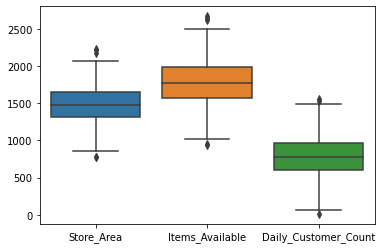

In [4]:
sns.boxplot(data = stores[['Store_Area','Items_Available','Daily_Customer_Count']])

<AxesSubplot:>

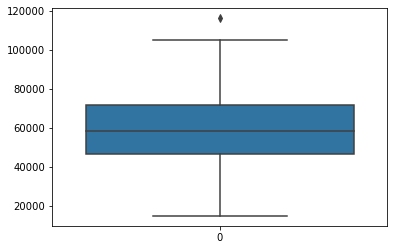

In [5]:
sns.boxplot(data = stores['Store_Sales'])

In [6]:
def remove_outliers(df, cols): #Accepts a dataframe and a list of columns
    Q1 = stores[cols].quantile(0.25)
    Q3 = stores[cols].quantile(0.75)
    IQR = Q3 - Q1

    df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

In [7]:
stores = remove_outliers(stores, ['Store_Area','Items_Available','Daily_Customer_Count', 'Store_Sales'])
stores.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


Check if the outliers were removed

<AxesSubplot:>

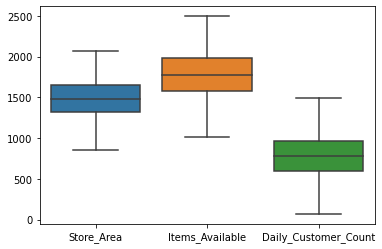

In [8]:
sns.boxplot(data = stores[['Store_Area','Items_Available','Daily_Customer_Count']])

Let's verify if we have some correlation between the variables

We will set the Store ID as an index!

In [9]:
stores.set_index('Store ID ',inplace = True)

<AxesSubplot:>

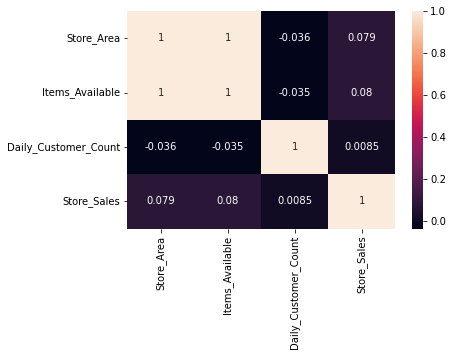

In [10]:
sns.heatmap(stores.corr(), annot = True)

So, we have perfect correlation between store area and items available, what makes sense.

However the total customers daily has a very weak correlation with the total Sales.

## Customer vs Sales & Items Available vs Sales

In [101]:
stores['Sales_per_Customer_Store'] = stores['Store_Sales'] / stores['Daily_Customer_Count']
stores['Sales_per_Area'] = stores['Store_Sales'] / stores['Store_Area']
stores['Sales_per_Items_Available'] = stores['Store_Sales'] / stores['Items_Available']
stores.head()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Sales_per_Customer_Store,Sales_per_Area,Sales_per_Items_Available
Store ID,,,,,,,
1,1659,1961,530,66490,125.452830,40.078360,33.906170
2,1461,1752,210,39820,189.619048,27.255305,22.728311
3,1340,1609,720,54010,75.013889,40.305970,33.567433
4,1451,1748,620,53730,86.661290,37.029635,30.737986
5,1770,2111,450,46620,103.600000,26.338983,22.084320


<AxesSubplot:xlabel='Sales_per_Area', ylabel='Sales_per_Customer_Store'>

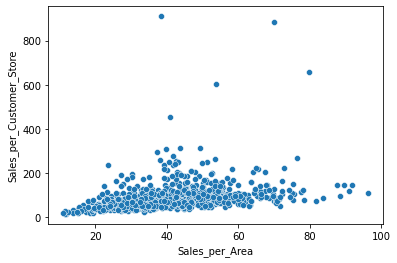

In [12]:
sns.scatterplot(x='Sales_per_Area', y = 'Sales_per_Customer_Store', data = stores)

<AxesSubplot:>

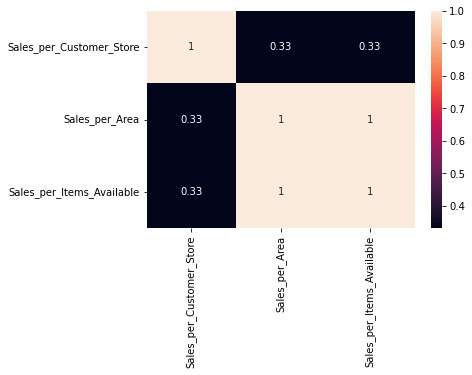

In [102]:
sns.heatmap(stores[['Sales_per_Customer_Store','Sales_per_Area','Sales_per_Items_Available']].corr(), annot = True)

We conclude that we have a weak to moderate correlation between the sales per customer and sales per area, meaning that each customer in average spends more money in stores with bigger area.

## Sales Predict - Linear Regression

In [90]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [19]:
stores.head()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Sales_per_Customer_Store,Sales_per_Area
Store ID,,,,,,
1,1659,1961,530,66490,125.452830,40.078360
2,1461,1752,210,39820,189.619048,27.255305
3,1340,1609,720,54010,75.013889,40.305970
4,1451,1748,620,53730,86.661290,37.029635
5,1770,2111,450,46620,103.600000,26.338983


We will try to predict the sales using the original dataset, however as we saw above this will probably be a poor predicting, because the correlation is not that good.

In [103]:
#Create arrays
X = stores.drop(['Store_Sales','Sales_per_Customer_Store','Sales_per_Area','Sales_per_Items_Available'], axis = 'columns').values
y = stores['Store_Sales'].values

#Divide the data into train and datates
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

#Start StandardScaler - Standardizing the data
scaler = StandardScaler()

#Start Linear Regression
lreg = LinearRegression()

#pipeline
pipeline = make_pipeline(scaler,lreg)

#Fit the model
pipeline.fit(X_train, y_train)

#Predict the values
y_pred = pipeline.predict(X_test)

print("Predictions: {}, Actual Values: {}".format(y_pred[:2], y_test[:2]))

Predictions: [56995.77741741 56430.61339539], Actual Values: [49720 94370]


Looking at the precdiction for two random sales. The first one is not good but the second one it's just ridiculous.

To prove this let's calculate the R^2 and RMSE (Error difference between the predicted and the real values).

In [104]:
#Compute R-Squared
r_squared = pipeline.score(X_test, y_test)

#Compute RMSE
rmse = mean_squared_error(y_test, y_pred, squared = False)

# Print the metrics
print("R^2: {}".format(r_squared))
print("RMSE: {}".format(rmse))

R^2: -0.0001607342207829987
RMSE: 17391.301358216788


So, we have a R^2 = 0, meaning that this linear regression model explains none of the variability of data.

So we have two options here,

- Or we give up (I don't think so ;) )
- Or we include the two new variables, Sales per Area & Sales per Customer Store

Model 2

In [105]:
#Create arrays
X = stores.drop(['Store_Sales'], axis = 'columns').values
y = stores['Store_Sales'].values

#Divide the data into train and datates
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

#Start StandardScaler - Standardizing the data
scaler = StandardScaler()

#Start Linear Regression
lreg = LinearRegression()

#pipeline
pipeline = make_pipeline(scaler,lreg)

#Fit the model
pipeline.fit(X_train, y_train)

#Predict the values
y_pred = pipeline.predict(X_test)

print("Predictions: {}, Actual Values: {}".format(y_pred[:2], y_test[:2]))

Predictions: [ 49782.45876846 108378.4640114 ], Actual Values: [49720 94370]


Looking at the Prediction the first one is very similar to real one.

Second one is not that far away. So I believe would be way better than the first one, but let's how well the model explain the variance.

In [106]:
#Compute R-Squared
r_squared = pipeline.score(X_test, y_test)

#Compute RMSE
rmse = mean_squared_error(y_test, y_pred, squared = False)

# Print the metrics
print("R^2: {}".format(r_squared))
print("RMSE: {}".format(rmse))

R^2: 0.9672037932101636
RMSE: 3149.263418694109


Nice!!!

Not only we had a very high R^2, explaining 96 of the variance in the data, but our RMSE is almost 6 times lower than the first one!!

But now, how do we know that Linear Regression is the best model.

Let's verify Ridge. Ridge regression  is to shrink features close to 0, to verify if overfitting and underfitting occurs.

- Ridge penalizes large positive or negative corefficients
- Ridge verifies that with increase of alpha what happens to our R^2 (Greater alpha, possible overfitting | Lower alpha, underfitting)

In [107]:
alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
ridge_scores = []
for alpha in alphas:
  
    # Create a Ridge regression model
    ridge = Ridge(alpha=alpha)
  
    # Fit the data
    ridge.fit(X_train,y_train)
  
    # Obtain R-squared
    score = ridge.score(X_test, y_test)
    ridge_scores.append(score)
print(ridge_scores)

[0.9672413513448629, 0.9675133536400851, 0.9682817110822809, 0.9685424023540068, 0.968112084636885, 0.9607231696015641]


The scores don't appear to change much as alpha increases, which is indicative 
of how well the features explain the variance in the target—even by heavily penalizing large coefficients, underfitting does not occur!

## What is/are the features that influence our model the most?

Lasso allow us to easy understand what are the features that most influence our model.

Lasso sets some features to 0, eliminating those features from the model instead of minimizing their impacts.

Let's firs initiate Lasso.

In [110]:
# Set up the parameter grid
param_grid = {"alpha": np.linspace(0.01, 1, 50)}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

lasso = Lasso(alpha=0.3, max_iter=1000000)

# Instantiate lasso_cv
lasso_cv = GridSearchCV(lasso, param_grid, cv=kf)

scaler = StandardScaler()
scaler.fit_transform(X_train,X_train)

# Fit to the training data
lasso_cv.fit(X_train, y_train)
print("Tuned lasso paramaters: {}".format(lasso_cv.best_params_))
print("Tuned lasso score: {}".format(lasso_cv.best_score_))

Tuned lasso paramaters: {'alpha': 0.01}
Tuned lasso score: 0.9515492350078215


Lasso has similar results to Linear Regression 0.95 < 0.96 for an hyperparameter tuning of alpha = 0.01

Let's now verify which features more contribute to our model.

[-2.89759547e+01  5.70558395e+01  1.26886077e+00  8.16999260e+00
 -1.16039630e+03  3.01022480e+03]


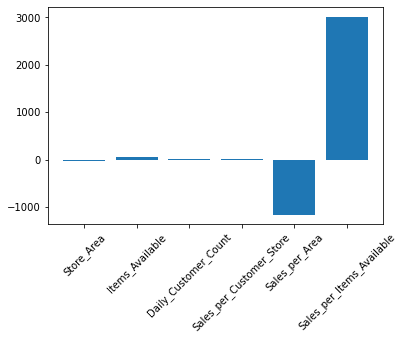

In [114]:
sales_columns = stores.drop(['Store_Sales'], axis = 'columns').columns
# Instantiate a lasso regression model
lasso = Lasso(alpha=0.01, max_iter=1000000)

# Fit the model to the data
lasso.fit(X, y)

# Compute and print the coefficients
lasso_coef = lasso.fit(X,y).coef_
print(lasso_coef)
plt.bar(sales_columns, lasso_coef)
plt.xticks(rotation=45)
plt.show()

See how the figure makes it clear that Sales_per_Items_Available is the most important feature in the treated dataset 
to predict sales values!

In [129]:
def plot_scatter(num_graphs, columns, data):
    fig, ax = plt.subplots((num_graphs), figsize = (10,8))
    count = 0
    for i in stores[columns]:
        graph = sns.scatterplot(x = 'Store_Sales', y = i, data = data, ax = ax[count])
        count += 1
    return graph

<AxesSubplot:xlabel='Store_Sales', ylabel='Sales_per_Items_Available'>

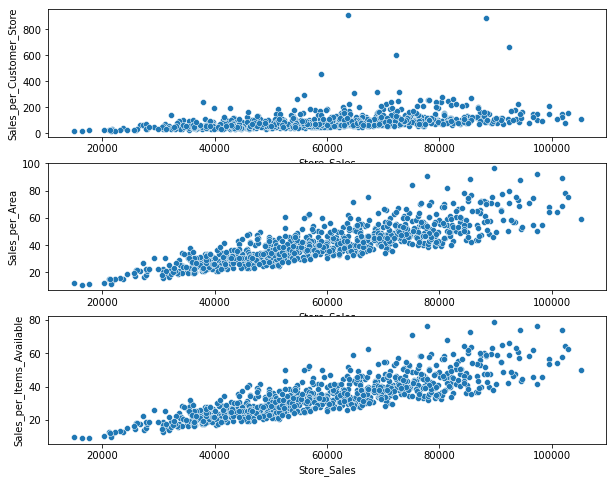

In [132]:
plot_scatter(3,['Sales_per_Customer_Store','Sales_per_Area','Sales_per_Items_Available'], stores)

## Conclusion

We were a able to develop a Model to predict Sales per Store.

We 'add' 3 new variables, Sales per customer in store, Sales_per_area (m^2) and Sales per Items Available to check correlation and to add the model three new variables that could be capital, as we could.

The model achieved an explained variance of 96%, what was really satisfying, RMSE (sum of errors between real and predict values) was lower too.

Ridge was used to shrink the features to near 0 and evaluate the model with under and overfitting. The model responded well and keep the efficiency without showing signs of under or overfitting.

Lasso was finally used to shrink some features to 0 and to work with those that are more significant, we verify that Sales per Item Available was the most important feature to predict sales in the different stores.

## Next Steps

As we could se for the graphs above Sales per m^2 & Sales per item is where the revenue increases the most.

As expand the store is not always possible and requires a big investment, we should focus the next analysis in Sales per items (It is the most important for our predicting model too).

And we suggest that,

- Clustering Analysis should be done between the items sold.

- We should verify in stores with lower variability of product, which are the products that we could reduce withou impact to much the selling of this.

- We should cluster the stores with biggest items and verify which are the products that people buy more that are not in the smaller stores.

- After this analysis we should propose a new arrangement of products for each store.